In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.misc
from scipy import ndimage
import cv2
%matplotlib inline

In [2]:
class NeuralNetwork:
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        self.lr = learningrate
        rng = np.random.default_rng(0)
#         self.wih = rng.random((hnodes, inodes)) - self.lr
#         self.who = rng.random((onodes, hnodes)) - self.lr
        # initial weights using this function leads to better results
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))
        self.act = lambda x: scipy.special.expit(x)  # sigmoid
    
    def train(self, inputs, targets):
        inputs = np.array(inputs, ndmin=2).T
        targets = np.array(targets, ndmin=2).T

        i_h = np.dot(self.wih, inputs)
        i_h_act = self.act(i_h)
        h_o = np.dot(self.who, i_h_act)
        h_o_act = self.act(h_o)
      
        e_h_o = targets - h_o_act
        bp_h_o = np.dot(self.who.T, e_h_o)

        self.who += self.lr * np.dot(e_h_o * h_o_act * (1.0 - h_o_act), i_h_act.T)
        self.wih += self.lr * np.dot(bp_h_o * i_h_act * (1.0 - i_h_act), inputs.T)
        
        return self.wih, self.who
    

    def query(self, inputs):
        inputs = np.array(inputs, ndmin=2).T
        i_h = np.dot(self.wih, inputs)
        i_h_act = self.act(i_h)
        h_o = np.dot(self.who, i_h_act)
        h_o_act = self.act(h_o)
        return h_o_act
                   

In [3]:
f1 = open("mnist/mnist_test.csv", 'r')
f2 = open("mnist/mnist_train.csv", 'r')
test_ln = f1.readlines()
train_ln = f2.readlines()
f1.close()
f2.close()

In [4]:
mnist_test = np.array([[np.uint8(s) for s in ln.strip().split(",")] for ln in test_ln])
mnist_train = np.array([[np.uint8(s) for s in ln.strip().split(",")] for ln in train_ln])
mnist_test.shape, mnist_train.shape

((10000, 785), (60000, 785))

In [5]:
mnist_train_scaled = mnist_train[:, 1:] / 255 * .99 + .01
mnist_test_scaled = mnist_test[:, 1:] / 255 * .99 + .01

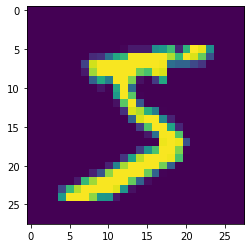

5

In [6]:
imgplot = plt.imshow(mnist_train_scaled[0].reshape((28,28)))
plt.show()
mnist_train[0,0]

In [7]:
inodes = mnist_train.shape[1]-1
hnodes = 100
onodes = len(np.unique(mnist_train[:, 0]))
lr = .01
dd = [-10, 10]

n = NeuralNetwork(inodes, hnodes, onodes, lr)
inputs = mnist_train_scaled
targets = mnist_train[:,0]
for k in range(10):
    for i in range(len(targets)):
        onehot = np.zeros(onodes) + .01
        onehot[targets[i]] = .99
        n.train(inputs[i], onehot)
        for d in dd:
            rot = ndimage.rotate(mnist_train[i, 1:].reshape(28, 28), d, reshape=False)
            rot = rot / 255 * .99 + .01
            n.train(rot.flatten(), onehot)


In [8]:
correct = 0
for i in range(len(mnist_test)):
    r = np.argmax(n.query(mnist_test_scaled[i]))
    correct += r == mnist_test[i, 0]
correct / mnist_test.shape[0]

0.971

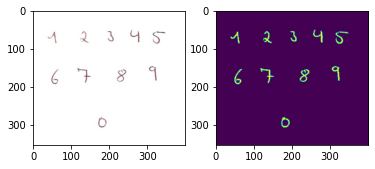

In [9]:
im = cv2.imread("handwritten.jpg")

_, sp = plt.subplots(1, 2)
sp[0].imshow(im)

im = cv2.bitwise_not(im)  # invert
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = im / 255 * .99 + .01
im = np.where(im > .1, .99, .01)
sp[1].imshow(im)
plt.show()

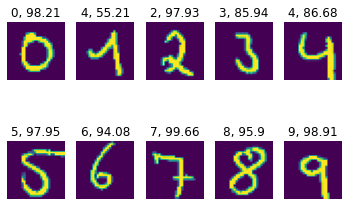

In [19]:
def raster(coo, w=40):
    return coo + w

coords = [(272, 161), (48, 30), (47, 113), (45, 181), (42, 244),
          (48, 303), (151, 35), (140, 110), (149, 209), (135, 292)]
sep = []
for c in range(len(coords)):
    y,x = coords[c]
    rst = 50 if c in [7, 6] else 40
    sep.append(cv2.resize(im[y:raster(y, rst), x:raster(x, rst)], dsize=(28, 28)))
    
subplots = plt.subplots(2, 5)
si = 0
for spa in subplots[1]:
    for sp in spa:
        sp.imshow(sep[si])
        sp.axis('off')
        r = n.query(sep[si].flatten())
        sp.title.set_text(str(np.argmax(r)) + ", " + str(round(np.max(r)*100, 2)))
        si += 1
plt.show()

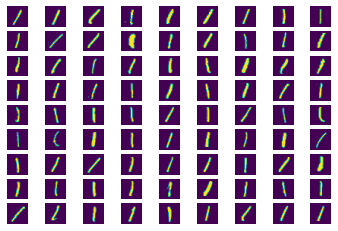

In [23]:
rows = 9; cols = 9
tt = mnist_train[:, 1:][mnist_train[:, 0] == 1]
np.random.shuffle(tt)
tt = tt[:rows*cols].reshape(rows*cols, 28, 28)
_, axes = plt.subplots(rows, cols)
i = 0
for rax in axes:
    for sp in rax:
        r = n.query(tt[i].flatten())
        sp.axis('off')
        sp.imshow(tt[i])
        i += 1
plt.show()
# that's just vertical lines